In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from joblib import dump, load
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

#### Rossmann is Germany's second-largest drug store chain, with over 3,600 stores in Europe.

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval-describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [3]:
df_train_dtypes = {"Store": int, 
                   "DayOfWeek": int,
                  "Date": "str",
                   "Sales": int,
                   "Customers": int,
                   "Open": int,
                   "Promo": int,
                   "StateHoliday": "str",
                   "SchoolHoliday": int}
train = pd.read_csv('https://raw.githubusercontent.com/ericxmagno/RossmanSalesPrediction/main/data/train.csv',dtype=df_train_dtypes, 
                       parse_dates=["Date"])
pd.set_option('display.max_columns',None)
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,4,2015-04-30,6228,650,1,1,0,0
1,2,4,2015-04-30,6884,716,1,1,0,0
2,3,4,2015-04-30,9971,979,1,1,0,0
3,4,4,2015-04-30,16106,1854,1,1,0,0
4,5,4,2015-04-30,6598,729,1,1,0,0
...,...,...,...,...,...,...,...,...,...
914624,1111,2,2013-01-01,0,0,0,0,a,1
914625,1112,2,2013-01-01,0,0,0,0,a,1
914626,1113,2,2013-01-01,0,0,0,0,a,1
914627,1114,2,2013-01-01,0,0,0,0,a,1


In [4]:
df_store_dtypes = {"Store": int, 
                   "StoreType": "str",
                  "Assortment": "str",
                    "PromoInterval": "str"}
store = pd.read_csv('https://raw.githubusercontent.com/becliu/MSBA-note/master/ml_class/MLDatasets/Rossmann%20Final%20Dataset/store.csv',dtype=df_store_dtypes)
pd.set_option('display.max_columns',None)
store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914629 entries, 0 to 914628
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Store          914629 non-null  int32         
 1   DayOfWeek      914629 non-null  int32         
 2   Date           914629 non-null  datetime64[ns]
 3   Sales          914629 non-null  int32         
 4   Customers      914629 non-null  int32         
 5   Open           914629 non-null  int32         
 6   Promo          914629 non-null  int32         
 7   StateHoliday   914629 non-null  object        
 8   SchoolHoliday  914629 non-null  int32         
dtypes: datetime64[ns](1), int32(7), object(1)
memory usage: 38.4+ MB


In [6]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int32  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int32(1), int64(1), object(3)
memory usage: 82.9+ KB


In [7]:
train.shape

(914629, 9)

In [8]:
store.shape

(1115, 10)

## Feature Exploration

In [9]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,914629.000000,914629.000000,914629.000000,914629.000000,914629.000000,914629.000000,914629.000000
mean,558.477923,3.996935,5755.722525,634.081021,0.830830,0.380417,0.180269
std,321.912653,1.998012,3842.448149,464.756658,0.374902,0.485489,0.384411
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,3711.000000,404.000000,1.000000,0.000000,0.000000
50%,558.000000,4.000000,5715.000000,609.000000,1.000000,0.000000,0.000000
75%,838.000000,6.000000,7826.000000,839.000000,1.000000,1.000000,0.000000
max,1115.000000,7.000000,38722.000000,7388.000000,1.000000,1.000000,1.000000


In [10]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


## Date Extraction

In [11]:
train["Year"] = train.Date.dt.year
train["Month"] = train.Date.dt.month
train["DayOfYear"] = train.Date.dt.dayofyear
train["WeekOfYear"] = train.Date.dt.weekofyear
train = train.reset_index()

C:\Users\AKSHAY~1\AppData\Local\Temp/ipykernel_6460/565492200.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train["WeekOfYear"] = train.Date.dt.weekofyear


In [12]:
df = pd.merge(train, store,how='left',on='Store')
df.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfYear,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,0,1,4,2015-04-30,6228,650,1,1,0,0,2015,4,120,18,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,2,4,2015-04-30,6884,716,1,1,0,0,2015,4,120,18,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,2,3,4,2015-04-30,9971,979,1,1,0,0,2015,4,120,18,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,3,4,4,2015-04-30,16106,1854,1,1,0,0,2015,4,120,18,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,4,5,4,2015-04-30,6598,729,1,1,0,0,2015,4,120,18,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [13]:
df.shape

(914629, 23)

## Check stores which are closed

In [14]:
df.Open.value_counts()

1    759901
0    154728
Name: Open, dtype: int64

#### To prevent bias all stores with 0 sales will be removed from the dataset. It can be automatically assumed that all Closed stores will have 0 sales.

In [15]:
df = df[df.Open == 1]
df = df.drop("Open", axis=1)

In [16]:
# see if there's any opened store with zero sales
df = df[df.Sales != 0]

In [17]:
# Create function for "HasCompetition" column
def competition(c):
    compYear = int(c["CompetitionOpenSinceYear"]) if not pd.isna(c["CompetitionOpenSinceYear"]) else -1
    compMonth = int(c["CompetitionOpenSinceMonth"]) if not pd.isna(c["CompetitionOpenSinceMonth"]) else -1
    if c["Year"] == compYear:
        if c["Month"] < compMonth:
            return 0
        else:
            return 1
    elif c["Year"] > compYear:
        return 1
    else:
        return 0

#### 
HasCompetition column will be based on "CompetitionOpenSinceMonth" and "CompetitionOpenSinceYear" being compared with the sales date columns.

Basically:

if the competition hasn't opened yet, HasCompetition = 0.

Otherwise HasCompetition = 1

Additionally, if "CompetitionOpenSince...." columns are NaN, it will be assumed that the stores always had competition.

In [18]:
df['HasCompetition'] = df.apply(competition, axis=1)

In [19]:
# Drop old competition columns
df = df.drop(columns=["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"])
df.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfYear,WeekOfYear,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,HasCompetition
0,0,1,4,2015-04-30,6228,650,1,0,0,2015,4,120,18,c,a,1270.0,0,NaN,NaN,NaN,1
1,1,2,4,2015-04-30,6884,716,1,0,0,2015,4,120,18,a,a,570.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1
2,2,3,4,2015-04-30,9971,979,1,0,0,2015,4,120,18,a,a,14130.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1
3,3,4,4,2015-04-30,16106,1854,1,0,0,2015,4,120,18,c,c,620.0,0,NaN,NaN,NaN,1
4,4,5,4,2015-04-30,6598,729,1,0,0,2015,4,120,18,a,a,29910.0,0,NaN,NaN,NaN,1


In [20]:
# Create function for 'HasPromo2' column
def promo(row):
    promoYear = int(row["Promo2SinceYear"]) if not pd.isna(row["Promo2SinceYear"]) else -1
    promoWeek = int(row["Promo2SinceWeek"]) if not pd.isna(row["Promo2SinceWeek"]) else -1
    promoMonthList = row["PromoInterval"].split(",") if not pd.isna(row["PromoInterval"]) else []
    
# Replace month strings with integer
    monthDict = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6, "Jul": 7, "Aug": 8, "Sept": 9, "Oct": 10,
                "Nov": 11, "Dec": 12}
    for idx, month in enumerate(promoMonthList):
        for k in monthDict:
            if k in month:
                promoMonthList[idx] = month.replace(k, str(monthDict[k]))
    promoMonthList = list(map(int, promoMonthList)) 
        
    if row["Year"] > promoYear:
        if row["Month"] in promoMonthList:
            return 1
    elif row["Year"] == promoYear:
        if row["WeekOfYear"] >= promoWeek:
            if row["Month"] in promoMonthList:
                return 1
    return 0   

#### 
HasPromo2 column will be used to determine whether or not the row at that point in time has an active Promo2. This will be determined by checking whether "Promo2SinceWeek" and "Promo2SinceYear" have started when compared with the sales date data. Afterwards the "PromoInterval" will be checked - whether or not the current month falls within the interval.

HasPromo2 = 1 if above conditions are satisfied

Otherwise, HasPromo2 = 0

In [21]:
df["HasPromo2"] = df.apply(promo, axis=1)
df.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfYear,WeekOfYear,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,HasCompetition,HasPromo2
0,0,1,4,2015-04-30,6228,650,1,0,0,2015,4,120,18,c,a,1270.0,0,NaN,NaN,NaN,1,0
1,1,2,4,2015-04-30,6884,716,1,0,0,2015,4,120,18,a,a,570.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1,1
2,2,3,4,2015-04-30,9971,979,1,0,0,2015,4,120,18,a,a,14130.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,1
3,3,4,4,2015-04-30,16106,1854,1,0,0,2015,4,120,18,c,c,620.0,0,NaN,NaN,NaN,1,0
4,4,5,4,2015-04-30,6598,729,1,0,0,2015,4,120,18,a,a,29910.0,0,NaN,NaN,NaN,1,0


In [22]:
# Drop irrelevant columns (Promo2 related, Date, Index)
df = df.drop(columns=["Promo2", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval", "Date"])
df.head()

,index,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfYear,WeekOfYear,StoreType,Assortment,CompetitionDistance,HasCompetition,HasPromo2
0,0,1,4,6228,650,1,0,0,2015,4,120,18,c,a,1270.0,1,0
1,1,2,4,6884,716,1,0,0,2015,4,120,18,a,a,570.0,1,1
2,2,3,4,9971,979,1,0,0,2015,4,120,18,a,a,14130.0,1,1
3,3,4,4,16106,1854,1,0,0,2015,4,120,18,c,c,620.0,1,0
4,4,5,4,6598,729,1,0,0,2015,4,120,18,a,a,29910.0,1,0


## Check for NaN columns

In [23]:
df.isna().sum()

index                     0
Store                     0
DayOfWeek                 0
Sales                     0
Customers                 0
Promo                     0
StateHoliday              0
SchoolHoliday             0
Year                      0
Month                     0
DayOfYear                 0
WeekOfYear                0
StoreType                 0
Assortment                0
CompetitionDistance    1959
HasCompetition            0
HasPromo2                 0
dtype: int64

In [24]:
df.fillna(df.median(), inplace=True)
df.isna().sum()

C:\Users\AKSHAY~1\AppData\Local\Temp/ipykernel_6460/1405725857.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.median(), inplace=True)


index                  0
Store                  0
DayOfWeek              0
Sales                  0
Customers              0
Promo                  0
StateHoliday           0
SchoolHoliday          0
Year                   0
Month                  0
DayOfYear              0
WeekOfYear             0
StoreType              0
Assortment             0
CompetitionDistance    0
HasCompetition         0
HasPromo2              0
dtype: int64

## Exploratory Data Analysis

Text(0.5, 1.0, 'Average Sales vs Promo')

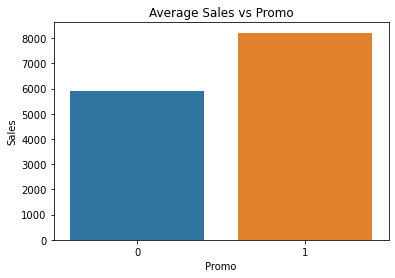

In [25]:
sns.barplot(x=df.Promo,y=df.Sales)
plt.title('Average Sales vs Promo')

Text(0.5, 1.0, 'Average Sales vs Has Promo')

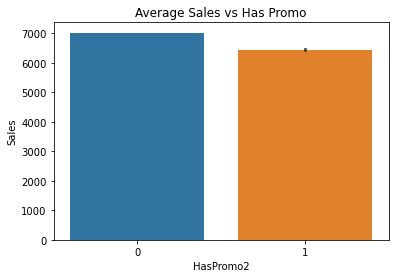

In [26]:
sns.barplot(x=df.HasPromo2,y=df.Sales)
plt.title('Average Sales vs Has Promo')

Text(0.5, 1.0, 'Average Sales in different types of stores')

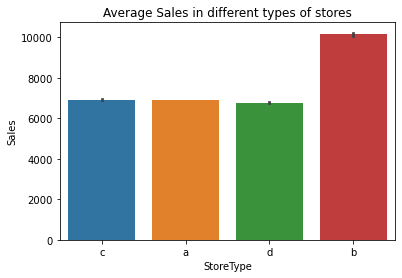

In [27]:
sns.barplot(x=df.StoreType,y=df.Sales)
plt.title('Average Sales in different types of stores')

Text(0.5, 1.0, 'Average Sales in different Assortment level')

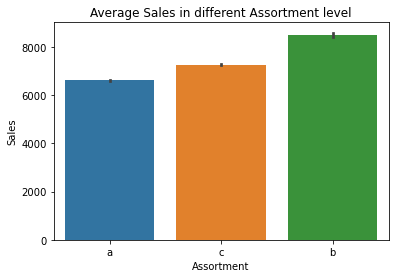

In [28]:
sns.barplot(x=df.Assortment,y=df.Sales)
plt.title('Average Sales in different Assortment level')

Text(0.5, 1.0, 'Average Sales in different Years')

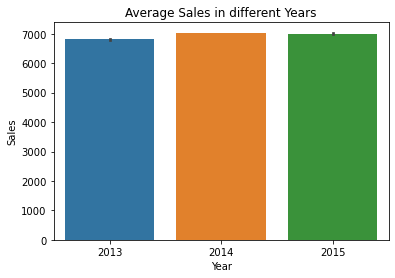

In [29]:
sns.barplot(x=df.Year,y=df.Sales)
plt.title('Average Sales in different Years')

Text(0.5, 1.0, 'Average Sales in State holidays')

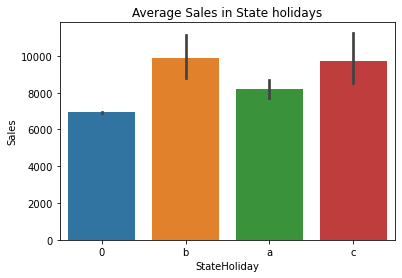

In [30]:
sns.barplot(x=df.StateHoliday,y=df.Sales)
plt.title('Average Sales in State holidays')

Text(0.5, 1.0, 'Average Sales in different Months')

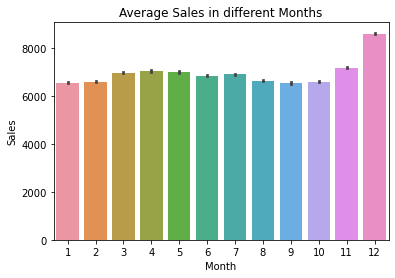

In [31]:
sns.barplot(x=df.Month,y=df.Sales)
plt.title('Average Sales in different Months')

Text(0.5, 1.0, 'Average Sales when having competition')

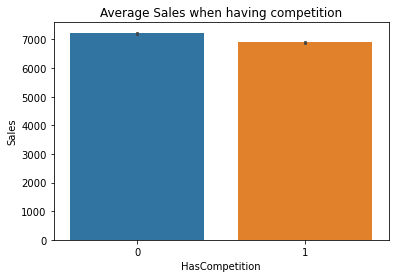

In [32]:
sns.barplot(x=df.HasCompetition,y=df.Sales)
plt.title('Average Sales when having competition')

## Convert object columns to category data type

In [33]:
df["StateHoliday"] = df["StateHoliday"].astype('category')
df["StoreType"] = df["StoreType"].astype('category')
df["Assortment"] = df["Assortment"].astype('category')
df["SchoolHoliday"] = df["SchoolHoliday"].astype('category')
df["HasCompetition"] = df["HasCompetition"].astype('category')
df["HasPromo2"] = df["HasPromo2"].astype('category')
df["Store"] = df["Store"].astype('category')

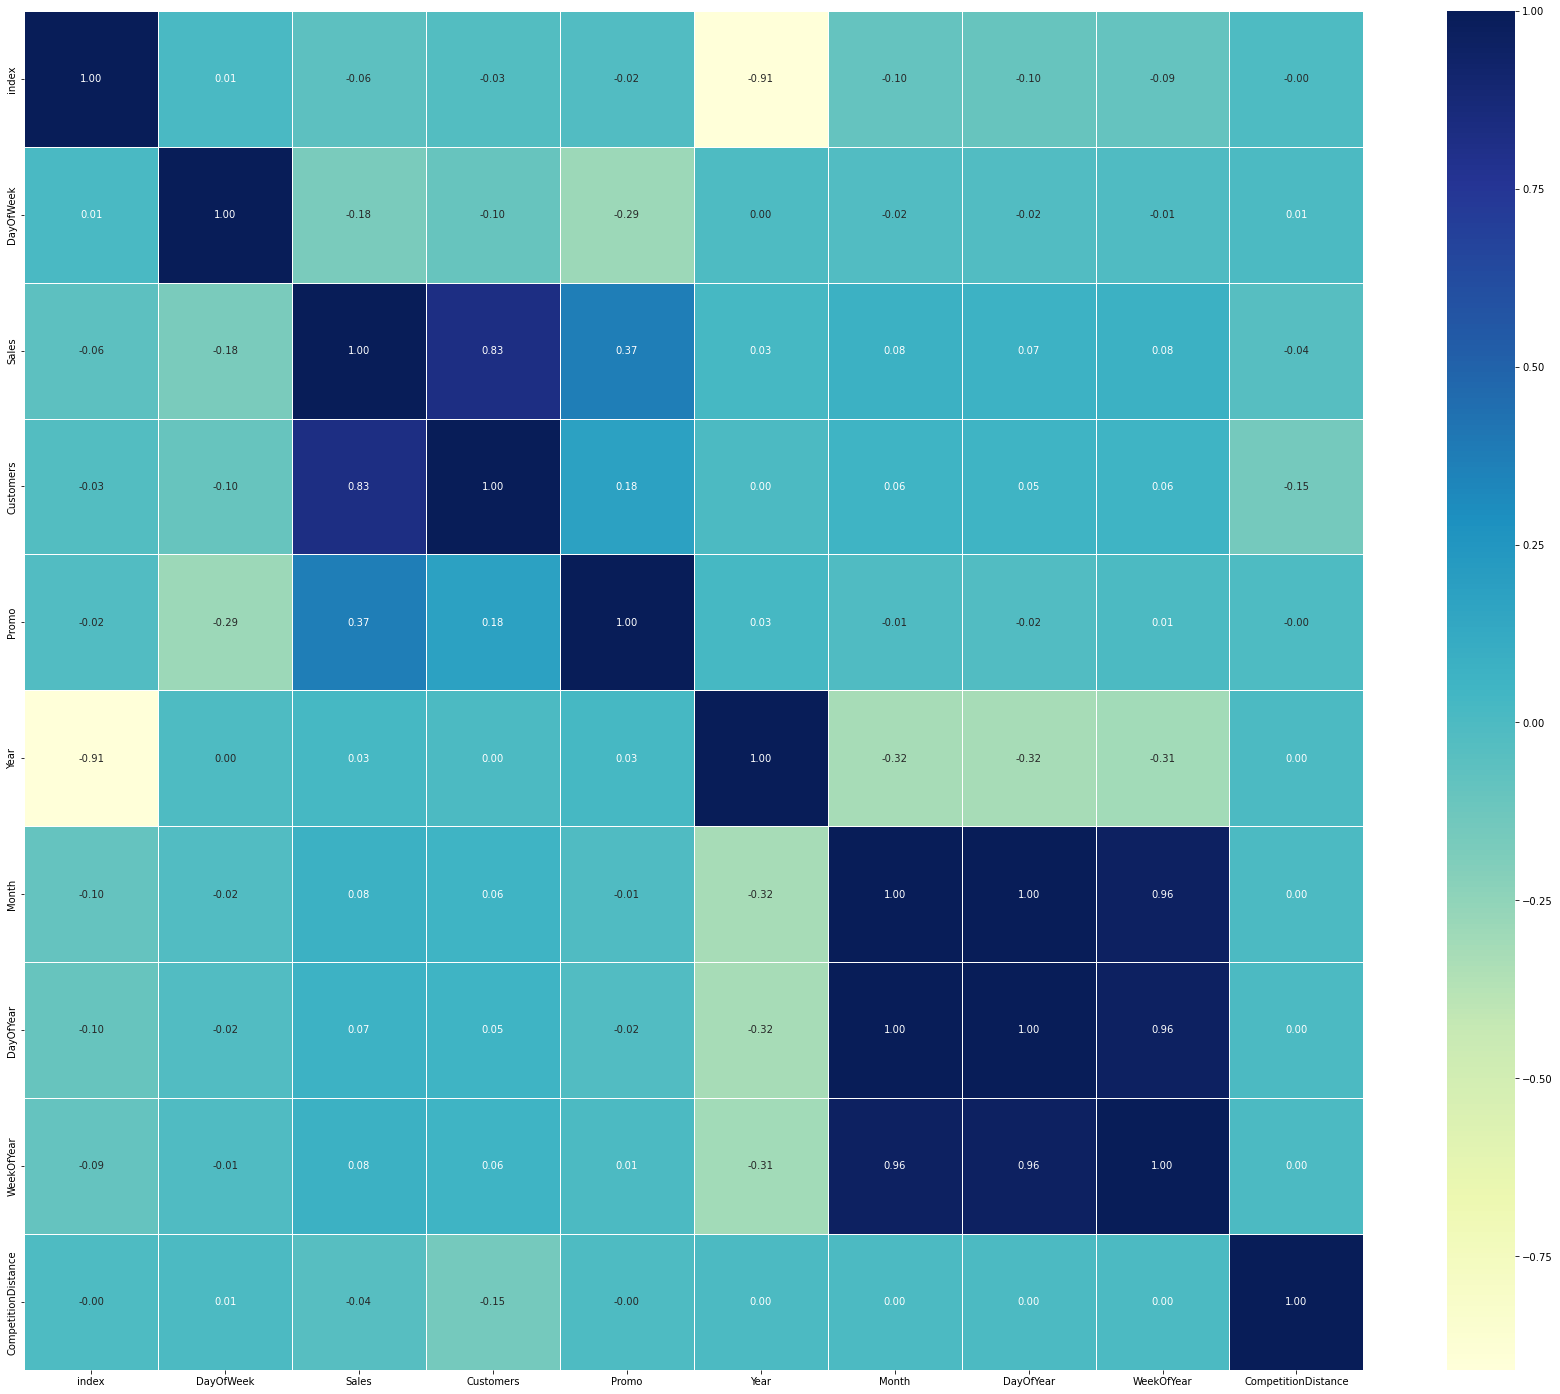

In [34]:
# Make a correlation matrix
corr_matrix = df.corr(method="pearson")
fig, ax = plt.subplots(figsize=(30,25))
ax = sns.heatmap(corr_matrix,
                annot=True,
                linewidths=0.5,
                fmt=".2f",
                cmap="YlGnBu")

#### It can be seen that Customer, Promo, and saleDayOfWeek have the highest impact on Sales

## Splitting the Data

In [35]:
X = df.drop(columns='Sales',axis=1)
Y = df['Sales']
X.shape, Y.shape

((759848, 16), (759848,))

In [36]:
# Set random seed
np.random.seed(42)

# Divide data into training, test, and validation (70-15-15 split)
Xtrain_pre, Xtest_pre, Ytrain, Ytest = train_test_split(X, Y, test_size=0.15, random_state=1)
Xtrain_pre, Xvalid_pre, Ytrain, Yvalid = train_test_split(Xtrain_pre, Ytrain, test_size=0.1765, random_state=1)
Xtrain_pre.shape, Xtest_pre.shape, Xvalid_pre.shape

((531873, 16), (113978, 16), (113997, 16))

In [37]:
Xtrain_pre

,index,Store,DayOfWeek,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfYear,WeekOfYear,StoreType,Assortment,CompetitionDistance,HasCompetition,HasPromo2
679680,679680,316,2,989,1,0,1,2013,7,211,31,d,a,9000.0,1,0
740980,740980,291,3,901,1,0,0,2013,6,156,23,d,a,2330.0,1,0
321566,321566,117,1,661,1,0,0,2014,6,167,25,a,a,3450.0,1,0
198409,198409,112,4,708,1,0,0,2014,10,296,43,a,a,1630.0,1,0
421508,421508,824,3,944,1,0,0,2014,3,78,12,a,a,17570.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301298,301298,166,6,923,0,0,0,2014,7,186,27,a,c,100.0,1,1
498155,498155,536,4,822,1,0,0,2014,1,9,2,a,c,4700.0,1,0
676442,676442,423,5,2643,1,0,1,2013,8,214,31,b,a,1270.0,0,0
756065,756065,881,4,483,0,0,0,2013,5,143,21,a,a,180.0,1,0


In [38]:
# OneHotEncode categorical features, and scale other features

preprocessor = None

# Setup preprocessing functions
def preprocess_X(data):
    # Define which features should be encoded vs scaled vs not touched
    columns_to_encode = ["StateHoliday", "StoreType", "Assortment", "SchoolHoliday", "Year", "Month", "DayOfWeek"]
    columns_to_scale  = ['Customers', 'CompetitionDistance']
    
    # encode cyclical data
    data = encode_cyclical(data, 'DayOfYear', 365)
    data = encode_cyclical(data, 'WeekOfYear', 52)
    
    global preprocessor
    if preprocessor is None:
        sscaler = StandardScaler()
        ohencoder = OneHotEncoder(handle_unknown='ignore')

        preprocessor = ColumnTransformer([
            ('scale', sscaler, columns_to_scale),
            ('encode', ohencoder, columns_to_encode)
        ], remainder='passthrough')
        
        preprocessor.fit(data)
        
        # Save preprocessor for API
        dump(preprocessor, 'preprocessor.joblib')
        
    processed_data = preprocessor.transform(data)
    

#     # Scale and Encode Separate Columns
#     scaled_columns = scaler.fit_transform(data[columns_to_scale]) 
#     encoded_columns = ohe.fit_transform(data[columns_to_encode])

#     # Concatenate (Column-Bind) Processed Columns Back Together
#     processed_data = np.concatenate([scaled_columns, encoded_columns], axis=1)
#     processed_data = pd.DataFrame(processed_data)
    
    return processed_data

def encode_cyclical(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data.loc[:,(col)]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data.loc[:,(col)]/max_val)
    data.drop(col, axis=1)
    return data

In [39]:
# Preprocess all X data
X_train = preprocess_X(Xtrain_pre)
X_valid = preprocess_X(Xvalid_pre)
X_test = preprocess_X(Xtest_pre)
X_train.shape

C:\Users\AKSHAY~1\AppData\Local\Temp/ipykernel_6460/162685054.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col + '_sin'] = np.sin(2 * np.pi * data.loc[:,(col)]/max_val)
C:\Users\AKSHAY~1\AppData\Local\Temp/ipykernel_6460/162685054.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col + '_cos'] = np.cos(2 * np.pi * data.loc[:,(col)]/max_val)


(531873, 48)

In [40]:
# Create evaluation function (Root Mean Square Log Error)

def rmse(Ytest, Ypreds):
    return np.sqrt(mean_squared_error(Ytest, Ypreds))

# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(Ytrain, train_preds),
              "Valid MAE": mean_absolute_error(Yvalid, val_preds),
              "Training RMSLE": rmse(Ytrain, train_preds),
              "Valid RMSLE": rmse(Yvalid, val_preds),
              "Training R^2": model.score(X_train, Ytrain),
              "Valid R^2": model.score(X_valid, Yvalid)}
    return scores

## Let's try RandomForestRegressor with hyperparameters tuned using RandomizedSearchCV

In [41]:
%%time

# Set random seed
np.random.seed(42)

# max_samples using 10% of training data as this takes way too long
max_samples = round(X_train.shape[0]*0.1)
# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [max_samples]}

rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=100,
                              cv=3,
                              n_jobs=-1,
                              verbose=True)

rs_model.fit(X_train, Ytrain)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Wall time: 38min 31s


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [53187],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [42]:
# Find the best parameters from the RandomizedSearch 
rs_model.best_params_

{'n_estimators': 40,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_samples': 53187,
 'max_features': 'auto',
 'max_depth': None}

In [43]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 475.76745863204184,
 'Valid MAE': 523.4437254927761,
 'Training RMSLE': 685.875698078191,
 'Valid RMSLE': 750.7901303225328,
 'Training R^2': 0.9512100167581828,
 'Valid R^2': 0.9420628550008289}

In [44]:
# Find the best score
rs_model.best_score_

0.9400420371963459

In [45]:
rs_model.score(X_test, Ytest)

0.9405630404201786

## Finally, let's try using GradiantBoostingRegressor with hyperparameters tuned using RandomizedSearchCV

In [46]:
%%time

# Set random seed
np.random.seed(42)

#gbr_grid = {'n_estimators':[500,1000,2000],
#            'learning_rate':[.001,0.01,.1],
#            'max_depth':[1,2,4],
#            'subsample':[.5,.75,1]}
#gbr_model = RandomizedSearchCV(GradientBoostingRegressor(),
#                               param_distributions=gbr_grid,
#                               n_iter=100,
#                               cv=3,
#                             n_jobs=-1,
#                               verbose=True)
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train, Ytrain)

Wall time: 5min 57s


GradientBoostingRegressor()

In [47]:
gbr_model.score(X_test, Ytest)

0.8824013749677271

In [48]:
show_scores(gbr_model)

{'Training MAE': 781.039600991791,
 'Valid MAE': 780.5385855262364,
 'Training RMSLE': 1061.8637743228662,
 'Valid RMSLE': 1062.3689012073808,
 'Training R^2': 0.8830561335628975,
 'Valid R^2': 0.8839966105566776}

#### GradientBoosting with RandomSearchCV was taking too long(1min per fit`)

## 
RandomForestRegressor scores best at ~94% on the test set and GradientBoostingRegressor(without hyperparameter tuning) at ~88%

Create new model using best parameters
but with max samples

{'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 53191, 'max_features': 'auto', 'max_depth': None}

In [49]:
%%time

# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=2,
                                    max_features="auto",
                                    n_jobs=-1,
                                    max_depth=None,
                                    max_samples=None,
                                   random_state=42)

ideal_model.fit(X_train, Ytrain)

Wall time: 3min 26s


RandomForestRegressor(n_estimators=40, n_jobs=-1, random_state=42)

In [50]:
show_scores(ideal_model)

{'Training MAE': 134.20507832696902,
 'Valid MAE': 351.75301016693413,
 'Training RMSLE': 208.98135315201137,
 'Valid RMSLE': 534.8943273307628,
 'Training R^2': 0.9954704515199789,
 'Valid R^2': 0.9705926449565725}

In [51]:
ideal_model.score(X_test, Ytest)

0.9693419971549746